# SENTIMENT ANALYSIS
Sentiment Analysis is contextual mining of text which identifies and extracts subjective information in source material, and helping a business to understand the social sentiment of their brand, product or service while monitoring online conversations.

Basic components of an opinion in Sentiment analysis divided by three :<Br>
- Opinion Holder : the person or organization that holds a specific opinion on a particular object.<br>
- Object : on which opinion is expressed.<br>
- Opinion : a view, attitude, or partial on an object from an opinion holder 
  
The usual class in sentiment classification of reviews is positive, negative, and neutral.
  
Here is the Sentiment Analysis flow on picture below:<br>

![Sentiment](Sentiment.JPG)

# Dataset and Objectives
**Source of Data**<br>
The data is originally came from Crowdflower's Data for Everyone library. This data was from twitter. <br>
**Objectives**<br>
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service"). 

# I. Import Libraries
To get started, let's import the libraries.

In [0]:
#!pip install wordcloud

In [42]:
import pandas as pd 
import numpy as np 

#import nltk for natural language toolkit
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords


#import string, regex, , uniqcode
import re, string, unicodedata

#import sklearn preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#import sklearn for modeling
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#import visualization module 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#import tqdm 
from tqdm import tqdm 
tqdm.pandas()

#import beaurtiful soup 
from bs4 import BeautifulSoup

#save model 
import pickle 

#textblob
from textblob import TextBlob
from textblob import Word

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# II. Load Data
Read data to perform Sentiment Analysis by input data as 'tweet' variable. Then, do some quick-look about data we're about to explore to understand the data itself.

In [62]:
tweet = pd.read_csv('tweets.csv')
tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0,NaN,NaN,Delta,NaN,JetBlueNews,NaN,0,@JetBlue's new CEO seeks the right balance to ...,NaN,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0,Can't Tell,0.6503,Delta,NaN,nesi_1992,NaN,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,NaN,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0,Late Flight,0.3460,United,NaN,CPoutloud,NaN,0,@united yes. We waited in line for almost an h...,NaN,2015-02-16 23:48:48 -0800,"Washington, DC",NaN
3,567592368451248130,negative,1.0,Late Flight,1.0000,United,NaN,brenduch,NaN,0,@united the we got into the gate at IAH on tim...,NaN,2015-02-16 23:52:20 -0800,NaN,Buenos Aires
4,567594449874587648,negative,1.0,Customer Service Issue,0.3451,Southwest,NaN,VahidESQ,NaN,0,@SouthwestAir its cool that my bags take a bit...,NaN,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)


In [5]:
tweet.shape

(14485, 15)

In [6]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14485 entries, 0 to 14484
Data columns (total 15 columns):
tweet_id                        14485 non-null int64
airline_sentiment               14485 non-null object
airline_sentiment_confidence    14485 non-null float64
negativereason                  9082 non-null object
negativereason_confidence       10416 non-null float64
airline                         14485 non-null object
airline_sentiment_gold          40 non-null object
name                            14485 non-null object
negativereason_gold             32 non-null object
retweet_count                   14485 non-null int64
text                            14485 non-null object
tweet_coord                     1007 non-null object
tweet_created                   14485 non-null object
tweet_location                  9798 non-null object
user_timezone                   9710 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


To continue the modeling, we need to drop some unuseful columns.

In [63]:
tweety=tweet.drop(['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', 'tweet_created', 'tweet_location','user_timezone'],axis=1)
tweety.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text
0,567588278875213824,neutral,1.0,NaN,NaN,Delta,JetBlueNews,0,@JetBlue's new CEO seeks the right balance to ...
1,567590027375702016,negative,1.0,Can't Tell,0.6503,Delta,nesi_1992,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...
2,567591480085463040,negative,1.0,Late Flight,0.3460,United,CPoutloud,0,@united yes. We waited in line for almost an h...
3,567592368451248130,negative,1.0,Late Flight,1.0000,United,brenduch,0,@united the we got into the gate at IAH on tim...
4,567594449874587648,negative,1.0,Customer Service Issue,0.3451,Southwest,VahidESQ,0,@SouthwestAir its cool that my bags take a bit...


Because the data itself is already have labeling, we can skip the 'Data Collection and LabelLing' step.

# III. Data Preprocessing
Prepare the data for modeling by basic data preprocessing, such as :<br>
1. Lower Casing 
2. Punctuation Removal 
3. Spelling correction 
4. Normalization 
5. Stopword removal
6. Tokenization 
7. Lemmatization 
8. Stemming

First, we need to cleanse the data such as drop the possibility of duplicate data.

In [0]:
#drop duplicate tweet 
g_unique = set()
for item in tweety['text']:
        g_unique.add(item) # ensures the element will only be copied if not already in the set
tweet = []
for item in g_unique:
    tweet.append(item)
    data = pd.DataFrame(tweet,columns = ['text'])

In [91]:
data.head()

,text
0,rhonda c at atlanta airport redeemed guy she g...
1,help me paid economy plus that wa changed bc o...
2,southwestair it never too late do right thing
3,jetblue looking cool
4,how is this considered time if it arriving at ...


Make all characters have the same meaning either uppercase or lowercase

In [106]:
#Lower Casing
data['text'] = data['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['text'].head()

0    rhonda c at atlanta airport redeemed guy she g...
1    help me paid economy plus that wa changed bc o...
2        southwestair it never too late do right thing
3                                 jetblue looking cool
4    how is this considered time if it arriving at ...
Name: text, dtype: object

Remove the punctuation character

In [107]:
#punctuation removal
data['text'] = data['text'].str.replace('[^\w\s]','')
data['text'].head()

0    rhonda c at atlanta airport redeemed guy she g...
1    help me paid economy plus that wa changed bc o...
2        southwestair it never too late do right thing
3                                 jetblue looking cool
4    how is this considered time if it arriving at ...
Name: text, dtype: object

 Remove the stopword in the tweets

In [108]:
#stopword removal
stop = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['text'].head()

0    rhonda c atlanta airport redeemed guy got u st...
1    help paid economy plus wa changed bc delay aut...
2                  southwestair never late right thing
3                                 jetblue looking cool
4    considered time arriving destination half hour...
Name: text, dtype: object

Remove the word that exist in all tweets

In [109]:
#frequents world removal
freq = pd.Series(' '.join(data['text']).split()).value_counts()[:10]
freq

usairways       3016
americanair     2778
southwestair    2426
jetblue         2336
wa              1584
get             1362
hour            1123
cancelled       1034
thanks          1003
u                998
dtype: int64

In [110]:
freq = list(freq.index)
data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
data['text'].head()

0    rhonda c atlanta airport redeemed guy got stra...
1    help paid economy plus changed bc delay automa...
2                               never late right thing
3                                         looking cool
4    considered time arriving destination half late...
Name: text, dtype: object

Remove the words that indicate as a rare word.

In [111]:
#rare words removal
rare_word = pd.Series(' '.join(data['text']).split()).value_counts()[-10:]
rare_word

distributor          1
httptcokvfwajvvid    1
problemjust          1
2707                 1
cbcallinaday         1
levi                 1
welp                 1
crossbrowser         1
httptcotkvcmhbpim    1
helpimstuck          1
dtype: int64

In [112]:
rare_word = list(rare_word.index)
data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
data['text'].head()

0    rhonda c atlanta airport redeemed guy got stra...
1    help paid economy plus changed bc delay automa...
2                               never late right thing
3                                         looking cool
4    considered time arriving destination half late...
Name: text, dtype: object

Make the original word from every words

In [113]:
#lematization 
data['text'] = data['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data['text'].head()

0    rhonda c atlanta airport redeemed guy got stra...
1    help paid economy plus changed bc delay automa...
2                               never late right thing
3                                         looking cool
4    considered time arriving destination half late...
Name: text, dtype: object

Separate every word

In [114]:
#tokenization
TextBlob(data['text'][1]).words

WordList(['help', 'paid', 'economy', 'plus', 'changed', 'bc', 'delay', 'automatically', 'refunded'])

Identify and repair the typo words

In [115]:
#Spelling correction
data['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    rhode c atlanta airport redeemed guy got strai...
1    help paid economy plus changed bc delay automa...
2                               never late right thing
3                                         looking cool
4    considered time arriving destination half late...
Name: text, dtype: object

# IV. Data Exploration
In this part, we will find the most frequent words by wordcloud and make sentiment chart.

In [116]:
#count sentiment 
sentiment = tweety.groupby(['airline_sentiment'])['airline_sentiment'].count()
sentiment

#make dataframe that will be created a chart 
chart = pd.DataFrame(sentiment)
chart['tweet_count'] = chart['airline_sentiment']
chart.drop(['airline_sentiment'], axis = 1, inplace = True )
chart = chart.reset_index()

#make a proportion of the number of tweet of each sentiment 
chart['percent'] = chart['tweet_count']/chart['tweet_count'].sum()
chart

,airline_sentiment,tweet_count,percent
0,negative,9082,0.626993
1,neutral,3069,0.211874
2,positive,2334,0.161132


## BarPlot

Text(0.5, 1.0, 'Sentiment Class')

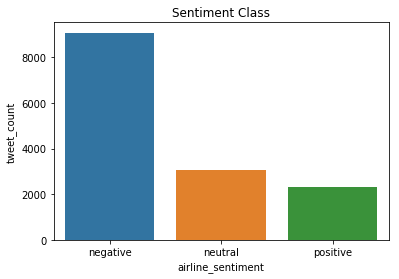

In [117]:
#visualization 
ax = sns.barplot(x= 'airline_sentiment', y='tweet_count', data=chart)
ax.set_title('Sentiment Class')

We can see that most of the tweet have sentiment that classifies into 'negative' class with more than 8000 tweets, while the second position classifies into 'neutral' class and the last is 'positive' class.

## WordCloud
Wordcloud is is useful for quickly perceiving the most prominent terms to determine its relative prominence. This prominent terms are determined by the size of the word appears. <br>
First, we will make wordcloud separately based on 'airline_sentiment'. Second, we're gonna make wordcloud by combining three of them.

In [0]:
#define positive, neutral, and negative
positive = tweety.loc[tweety['airline_sentiment'] == "positive"]
neutral = tweety.loc[tweety['airline_sentiment'] == "neutral"]
negative = tweety.loc[tweety['airline_sentiment'] == "negative"]

In [0]:
#merge all the happy comments into one paragraph
all_text_positive = "".join(positive.text.values)
all_text_neutral = "".join(neutral.text.values)
all_text_negative = "".join(negative.text.values)

In [0]:
#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

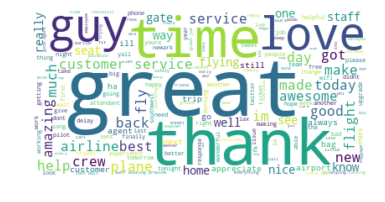

None


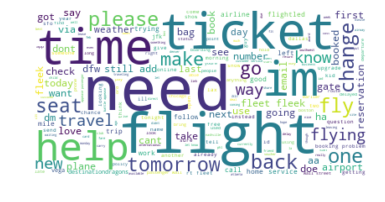

None


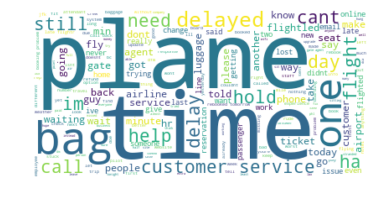

None


In [121]:
#First, separate wordcloud

#positive
print(create_word_cloud(all_text_positive))
#neutral
print(create_word_cloud(all_text_neutral))
#negative
print(create_word_cloud(all_text_negative))

We can see form those wordcloud above that : <br>
1. On positive wordcloud, the most prominent terms is **great**. So, it means that most of users with positive sentiment tweeting that contains **great** word.
2. On neutral wordcloud, the most prominent terms is **need** and **flight**. So, it means that most of users with neutral sentiment tweeting that contains **need** and **flight** words.
3. On negative wordcloud, the most prominent terms is **plane** and **time**. So, it means that most of users with negative sentiment tweeting that contains **plane** and **time** words.

In [0]:
#Second, combination wordcloud

wordc = "".join(tweety.text.values)

In [0]:
#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

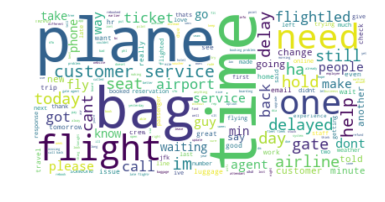

In [124]:
create_word_cloud(wordc)

Based on worldcloud of combination three sentiment, can be seen that most prominent terms is **time**, **plane**, **bag**, **flight**, **need**, etc. So, it means that most of users with combination of all sentiment tweeting that contains those words.

In [0]:
## WordCloud Negative Reason of Negative Sentiment
negative  = tweety.loc[tweety['airline_sentiment'] == "negative"]


In [0]:
negative = "".join(negative.negativereason.values)

In [0]:
#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

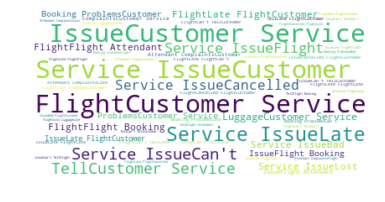

In [130]:
create_word_cloud(negative)

Based on Negative Reason of Negative Sentiment above, it can be seen that there are some Negative Reason that have the biggest appearance, such as :
- Flight Customer Service
- Service Customer Service
- Issue Customer Service
- Service Issue Late
- etc

It means that the possible reason for negative tweet about the airline is the airline company itself. They need to make some training program for their newcomers and train them to become customer centric and can give service better than before.

# V. Exploratory Data Analysis (EDA)
Performing EDA to visualize the results.

## Pie Chart

In [132]:
tweety['airline'].unique()

array(['Delta', 'United', 'Southwest', 'US Airways', 'Virgin America',
       'American'], dtype=object)

Text(0.5, 1.0, 'Tweets Frequency by Airline')

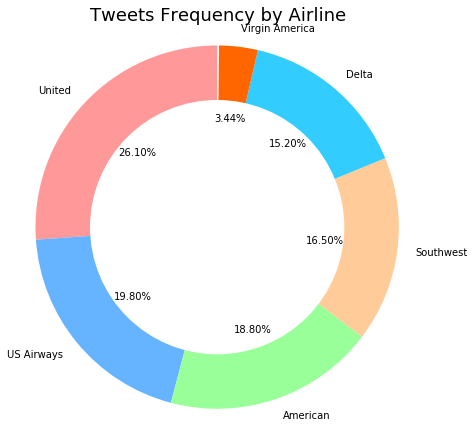

In [133]:
#Pie chart of tweets frequency for each airline
labels = ['United','US Airways','American','Southwest','Delta','Virgin America']
sizes = [0.261, 0.198, 0.188, 0.165, 0.152, 0.0344]
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#33ccff', '#ff6600']
fig1, ax1 = plt.subplots(figsize=(6.5, 6))
ax1.pie(sizes, colors=colors, labels=labels, autopct='%1.2f%%', startangle=90)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.title('Tweets Frequency by Airline', fontsize=18)

We can see that from pie chart above, **United** have highest tweet frequency with 26.10% and the least is Virgin America which is 3.44%. It also can be interpret that **United** have some impact on the customer that causes the customer to do a review or description via Twitter.

## Stack Bar

In [134]:
#customers feel about each airline
pd.crosstab(tweety.airline, tweety.airline_sentiment)

airline_sentiment,negative,neutral,positive
airline,,,
American,1864,433,307
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


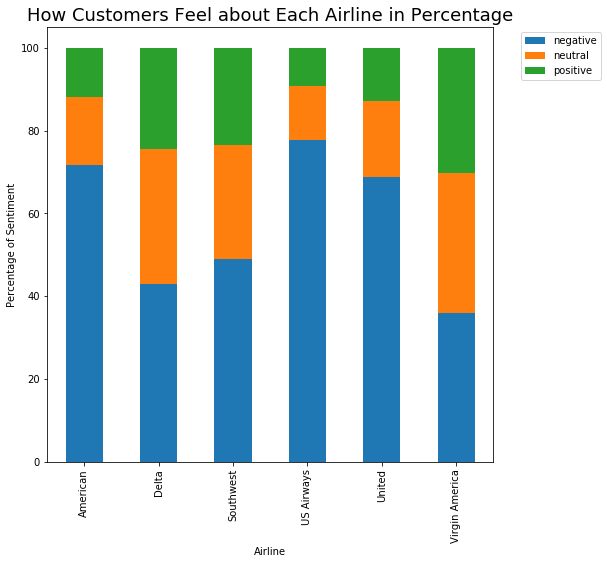

In [135]:
#Visualize sentiment in precentage per airline
_ = pd.crosstab(tweety.airline, tweety.airline_sentiment).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar',title='How Customers Feel about Each Airline in Percentage',figsize=(8,8),stacked=True)
_.title.set_size(18)
_.set_xlabel('Airline')
_.set_ylabel('Percentage of Sentiment')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

If it is related to the results of Pie Chart visualization above, it can be seen that although **United** has some influence on customer sentiment, it turns out that the majority of customers tweet negative sentiments towards United. Meanwhile, for **Virgin America**, although it has a small influence on the behavior of customer tweets, the proportion of customer tweet sentiments is relatively the same for each sentiment class and is the best compared to other airlines.

In [142]:
tweety['negativereason'].unique()

array([nan, "Can't Tell", 'Late Flight', 'Customer Service Issue',
       'Bad Flight', 'Flight Booking Problems', 'Lost Luggage',
       'Cancelled Flight', 'Flight Attendant Complaints', 'longlines',
       'Damaged Luggage'], dtype=object)

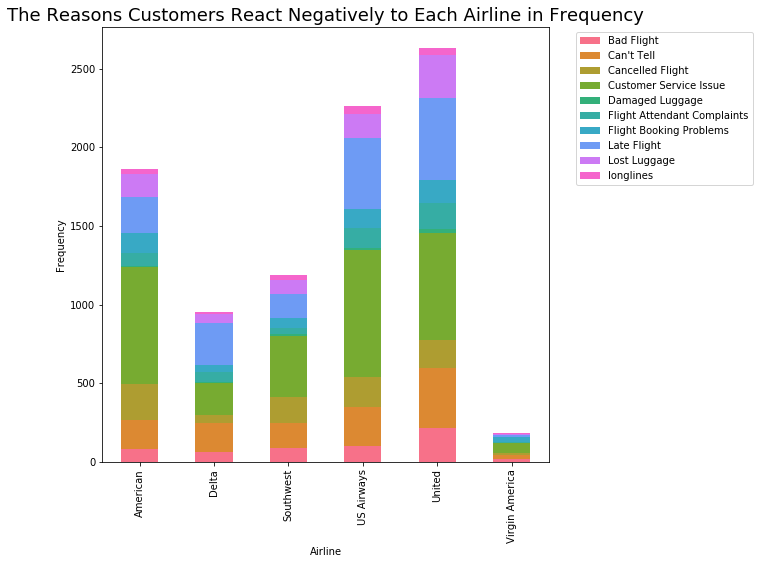

In [147]:
#Visualize negative reasons per airline
colors = sns.color_palette('husl',10)
pd.crosstab(tweety.airline, tweety.negativereason).plot(kind='bar',color=colors,figsize=(8,8),stacked=True)
plt.title('The Reasons Customers React Negatively to Each Airline in Frequency', fontsize=18)
plt.xlabel('Airline')
plt.ylabel('Frequency')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

From Negative Reason stacked bar above, it can be seen that the highest reason customer gives negative tweets is approximately because of Customer Service Issue, and the second highest reason pretty much is because of Late Flight.

# VI. Conclusion

There are some conclusion we can get from this Sentiment Analysis : <br>
- As any text data, tweets are quite unclean having punctuations, numbers and short cuts. To understand real user opinions, complaints and suggestions, we have to again filter the the unrelated Tweets(Spam, junk, marketing, news and random).
- Most of the short cuts or abbreviations can either be transformed or dropped. I have dropped them here for, I don't have complete details on them.
- In Business, companies use it to develop their strategies, to understand customers’ feelings towards products or brand, how people respond to their campaigns or product launches and why consumers don’t buy some products. 

In this case, these results and visualization to improve their service, train and give attention to the crew, ensure that the procedure is carried out effectively. Or on another's view, ensure flight operations run according to the schedule and with appropriate services, if there are errors that will be immediately corrected, compensate the injured party, etc.